# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing.imputation import Imputer

# magic word for producing visualizations in notebook
%matplotlib inline
sns.set(style="darkgrid")

In [2]:
import sklearn
sklearn.__version__

'0.19.1'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print("General Demographics data has {0} rows and {1} columns".format(azdias.shape[0], azdias.shape[1]))
print("Feature Summary information has {0} rows and {1} columns".format(feat_info.shape[0], feat_info.shape[1]))


General Demographics data has 891221 rows and 85 columns
Feature Summary information has 85 rows and 4 columns


In [5]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

# Check null values

In [7]:
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [8]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [9]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [10]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [11]:
feat_info.isnull().sum()

attribute             0
information_level     0
type                  0
missing_or_unknown    0
dtype: int64

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [12]:
# Identify missing or unknown data values and convert them to NaNs.
missing_df = pd.DataFrame(columns=['attribute',
                                   'missing_or_unknown_count',
                                   'natural_missing_count', 
                                   'total_missing_count'])

In [13]:
missing_df.attribute = feat_info.attribute

In [14]:
def get_missing_value_codes(df):
    '''
       Convert the string representation of list missing codes to list.
    '''
    attribute = df['attribute']
    str_list = df['missing_or_unknown']
    if len(str_list.strip("][")):
        tmp = [ data.strip('][') for data in str_list.split(",")]
        missing_codes = [ int(data) if data[0]=='-' or data.isdigit() else data for data in tmp]
    else:
        missing_codes = []
    return (attribute, missing_codes)


In [15]:
missing_value_codes = feat_info.apply(get_missing_value_codes, axis=1)

In [16]:
def transform_missing_codes_to_nan(df, missing_value_codes):
    '''
       Transforms missing codes to NaN. 
       It also counts how many natural missing and also counts how many missing by codes.
       Input: dataframe, list of tuple(attribut, missing_code)
       Output: Returns transformerd_dataframe, list of nautral missing counts, list of missing code counts
    '''
    natural_missing_counts = []
    missing_code_counts = []

    for attr, code in missing_value_codes:
        
        #Find natural missing 
        natural_missing = df[attr].isnull().sum()
        natural_missing_counts.append(natural_missing)

        for curr_code in code:
            tmp = df[attr].value_counts()
            if curr_code in tmp.index:
                df[attr] = df[attr].replace(curr_code, np.nan)
    
        #Find missing by codes
        missing_code_count = df[attr].isnull().sum() - natural_missing
        missing_code_counts.append(missing_code_count)

        #total = natural_missing + missing_code_count
        #print(attr, natural_missing, missing_code_count, total )
        
        
    return df, natural_missing_counts, missing_code_counts

In [17]:
azdias_transformed, natural_missing_counts , missing_code_counts = \
                                                            transform_missing_codes_to_nan(azdias, missing_value_codes)

In [18]:
missing_df.missing_or_unknown_count = missing_code_counts
missing_df.natural_missing_count = natural_missing_counts

In [19]:
missing_df.total_missing_count = missing_df.missing_or_unknown_count + missing_df.natural_missing_count

In [20]:
missing_df

,attribute,missing_or_unknown_count,natural_missing_count,total_missing_count
0,AGER_TYP,685843,0,685843
1,ALTERSKATEGORIE_GROB,2881,0,2881
2,ANREDE_KZ,0,0,0
3,CJT_GESAMTTYP,0,4854,4854
4,FINANZ_MINIMALIST,0,0,0
5,FINANZ_SPARER,0,0,0
6,FINANZ_VORSORGER,0,0,0
7,FINANZ_ANLEGER,0,0,0
8,FINANZ_UNAUFFAELLIGER,0,0,0
9,FINANZ_HAUSBAUER,0,0,0


In [21]:
print("Total missing data counts by missing_or_unknown codes : {}"
                                                          .format(missing_df.missing_or_unknown_count.sum()))


print("Total natural missing data : {}" .format(missing_df.natural_missing_count.sum()))



Total missing data counts by missing_or_unknown codes : 3477091
Total natural missing data : 4896838


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

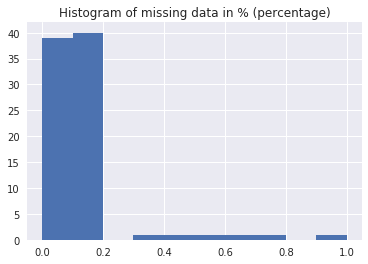

In [22]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
plt.title("Histogram of missing data in % (percentage)")
_ = plt.hist(azdias_transformed.isnull().sum() / azdias_transformed.shape[0])


In [23]:
# Investigate patterns in the amount of missing data in each column.
azdias_transformed.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

# How many times same amount of null values present ?

In [24]:
(azdias_transformed.isnull().sum()/azdias_transformed.shape[0])#.value_counts()

AGER_TYP                 0.769554
ALTERSKATEGORIE_GROB     0.003233
ANREDE_KZ                0.000000
CJT_GESAMTTYP            0.005446
FINANZ_MINIMALIST        0.000000
FINANZ_SPARER            0.000000
FINANZ_VORSORGER         0.000000
FINANZ_ANLEGER           0.000000
FINANZ_UNAUFFAELLIGER    0.000000
FINANZ_HAUSBAUER         0.000000
FINANZTYP                0.000000
GEBURTSJAHR              0.440203
GFK_URLAUBERTYP          0.005446
GREEN_AVANTGARDE         0.000000
HEALTH_TYP               0.124768
LP_LEBENSPHASE_FEIN      0.109549
LP_LEBENSPHASE_GROB      0.106115
LP_FAMILIE_FEIN          0.087287
LP_FAMILIE_GROB          0.087287
LP_STATUS_FEIN           0.005446
LP_STATUS_GROB           0.005446
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
RETOURTYP_BK_S           0.005446
SEMIO_SOZ                0.000000
SEMIO_FAM                0.000000
SEMIO_REL                0.000000
SEMIO_MAT                0.000000
SEMIO_VERT               0.000000
SEMIO_LUST    

In [25]:
(azdias_transformed.isnull().sum()).value_counts()

0         24
116515     7
4854       6
133324     6
93148      4
73499      4
111196     3
99352      3
93740      3
97375      2
77792      2
158064     2
93155      1
584612     1
108164     1
685843     1
147988     1
99611      1
97274      1
108315     1
73969      1
18348      1
97632      1
476524     1
2881       1
105800     1
97008      1
310267     1
94572      1
889061     1
392318     1
dtype: int64

In [26]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)


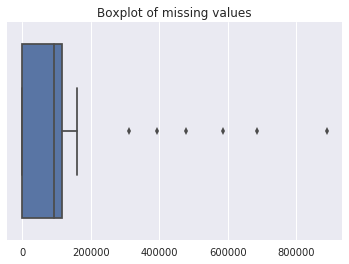

In [27]:
plt.title("Boxplot of missing values")
sns.boxplot(azdias_transformed.isnull().sum())

In [28]:
def drop_outlier_features(df):
    '''
        Drop outiler features that has large amount of missing values.
        Input: dataframe
        Output: dataframe (after outlier features removal) 
    '''
    _ = df.isnull().sum()
    IQ1 = np.percentile(_,25) # first Quartile
    IQ3 = np.percentile(_,75) # third Quartile
    IQR = IQ3 - IQ1 # Inter Quartile Range
    outliers = _.index[~((_ >= IQ1 - (IQR * 1.5)) & (_ <= IQ3 + (IQR * 1.5)))]
    print(outliers)
    return df.drop(outliers, axis=1)


In [29]:
azdias_transformed = drop_outlier_features(azdias_transformed)

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')


#### Discussion 1.1.2: Assess Missing Data in Each Column

 > **Amount of missing data ?**
 
         Total missing data counts by missing_or_unknown codes : 3477091
         Total natural missing data : 4896838

 > **Pattern in missing values ?**

        Definitely we can see a pattern in missing data.
        For examples: 
        
        All PLZ8 region related features has same amount of missing data
            PLZ8_ANTG1               116515
            PLZ8_ANTG2               116515
            PLZ8_ANTG3               116515
            PLZ8_ANTG4               116515
            PLZ8_BAUMAX              116515
            PLZ8_HHZ                 116515
            PLZ8_GBZ                 116515
            
       KBA05 micro-cell features also has same amount of missing data
            KBA05_ANTG1              133324
            KBA05_ANTG2              133324
            KBA05_ANTG3              133324
            KBA05_ANTG4              133324
            KBA05_GBZ                133324
       
 > **Outliers ?**
 
         We have identified 6 features as an outliers in terms of missing data. 
         With the help of boxplot drawn above it is very easy to identify the outliers. 
         They have more than 200000 missing data per features. 
         Identified outlier features are as follows:-
         AGER_TYP
         GEBURTSJAHR
         TITEL_KZ
         ALTER_HH
         KK_KUNDENTYP
         KBA05_BAUMAX


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

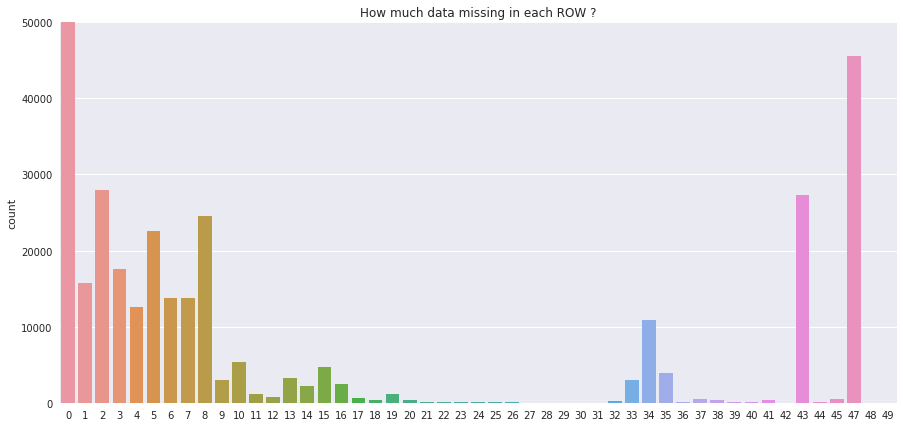

In [30]:
# How much data is missing in each row of the dataset?
plt.figure(figsize=(15,7))
plt.title("How much data missing in each ROW ?")
plt.ylim(0, 50000)
sns.countplot(azdias_transformed.isnull().sum(axis=1).values)

In [31]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

def divide_data_by_missing_threshold(df, threshold):
    '''
        Divide data in two parts with the help of threshold.
        Input: dataframe , threshold
        Output: dataframe_part1, dataframe_part2
    '''
    mask = df.isnull().sum(axis=1) > threshold
    df_lower = df[~mask]
    df_higher = df[mask]
    return df_lower, df_higher


In [63]:
df_until_threshold, df_with_greater_than_threshold = divide_data_by_missing_threshold(azdias_transformed, 19)
print(df_until_threshold.shape)
print(df_with_greater_than_threshold.shape)

(797077, 79)
(94144, 79)


In [44]:
random.seed(10)

In [34]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_datasets(df1, df2, max_features):
    '''
        Compare datasets by drawing counplot for different features.
        Input: dataframe_1, dataframe_2, max_features
            max_features: how many features to use for comparasion.
        Return: None
    '''
    missing_values_columns = sorted(list(set(df1.columns[df1.isnull().sum() > 0]) | set(df2.columns[df2.isnull().sum() > 0])))
    print(len(missing_values_columns))
    features = [missing_values_columns[random.randrange(0,len(missing_values_columns))] for i in range(max_features)]
    
    for feature in features:
        fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

        sns.countplot(df1[feature], ax=ax1)
        sns.countplot(df2[feature], ax=ax2)


55


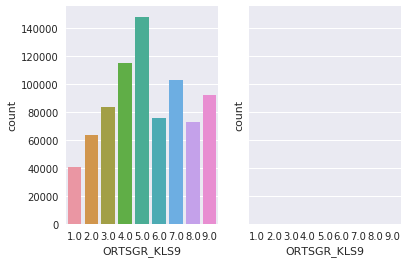

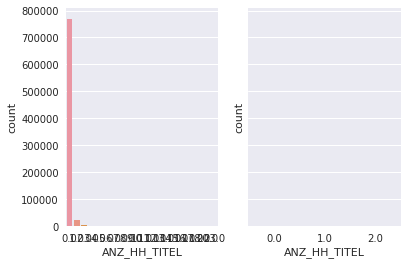

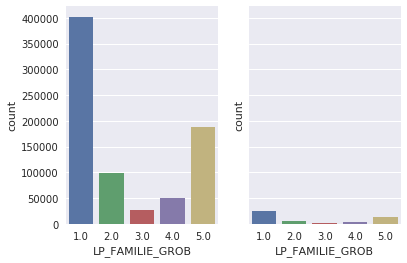

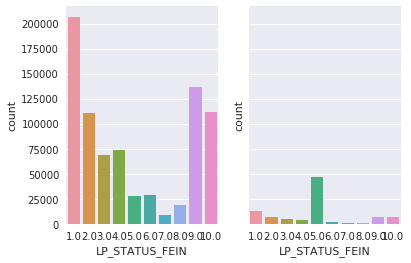

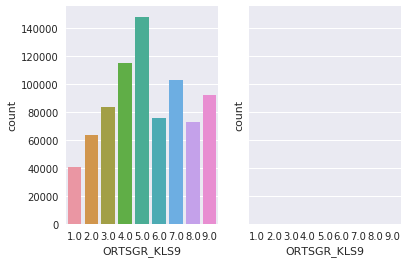

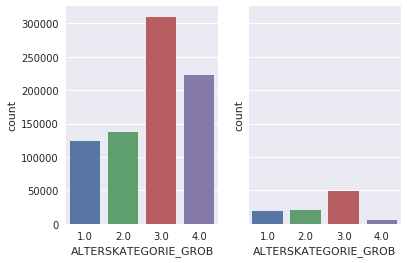

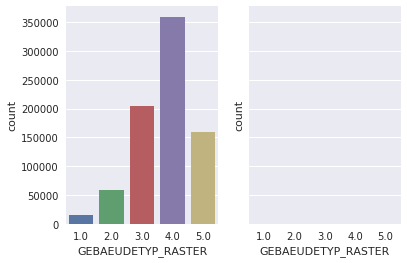

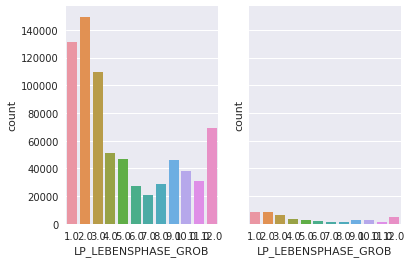

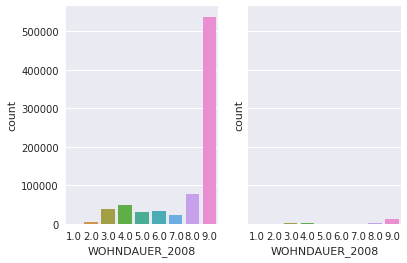

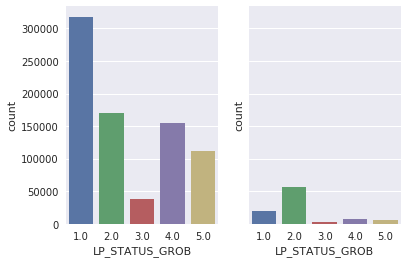

In [35]:
compare_datasets(df_until_threshold, 
                 df_with_greater_than_threshold, 
                 10)

#### Discussion 1.1.3: Assess Missing Data in Each Row

 > **Are the data with lots of missing values are qualitativerly different from data with few or no missing values ?**
 
     Out of 10 plots drawn above, most featues has different data distribution in comparision with few_missing_values and missing_values dataset. For example:
     
        ALTERSKATEGORIE_GROB

        GEBAEUDETYP_RASTER

        WOHNDAUER_2008

        ANZ_HH_TITEL
        
        LP_STATUS_FEIN

# Impute missing values

In [64]:
missing_columns = df_until_threshold.columns[ df_until_threshold.isnull().sum() > 0]
print(len(missing_columns))

for col in missing_columns:
    most_freq = df_until_threshold[col].mode()[0]
    df_until_threshold[col] = df_until_threshold[col].fillna(most_freq)

46


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [65]:
df_until_threshold.isnull().sum()

ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
CJT_GESAMTTYP            0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
FINANZTYP                0
GFK_URLAUBERTYP          0
GREEN_AVANTGARDE         0
HEALTH_TYP               0
LP_LEBENSPHASE_FEIN      0
LP_LEBENSPHASE_GROB      0
LP_FAMILIE_FEIN          0
LP_FAMILIE_GROB          0
LP_STATUS_FEIN           0
LP_STATUS_GROB           0
NATIONALITAET_KZ         0
PRAEGENDE_JUGENDJAHRE    0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
                        ..
MIN_GEBAEUDEJAHR         0
OST_WEST_KZ              0
WOHNLAGE                 0
CAMEO_DEUG_2015          0
CAMEO_DEU_2015           0
CAMEO_INTL_2015          0
K

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [66]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [67]:
print("azdias dataframe has 49 ordinal, 21 categorical, 7 mixed, 7 numeric and 1 interval type features")

azdias dataframe has 49 ordinal, 21 categorical, 7 mixed, 7 numeric and 1 interval type features


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [68]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

def assess_categorical_features(df):
    '''
        Assess Categorical Features function finds binary and multi-level categorical variables.
        It also finds which one required encoding or not.
    '''
    categorical_features = feat_info[feat_info.type == 'categorical']['attribute']
    binary_categorical_numeric_encoded = []
    binary_categorical_required_encoding = []
    multi_level_required_encoding = []

    for feature in categorical_features:
        #print(feature)

        #This check is requried because we have dropped few high missing values features 
        if feature in df.columns:
            if len(df[feature].unique()) == 2:
                if df[feature].dtype == 'object':
                    binary_categorical_required_encoding.append(feature)
                else:
                    binary_categorical_numeric_encoded.append(feature)
            else:
                multi_level_required_encoding.append(feature)
                
    return binary_categorical_numeric_encoded, binary_categorical_required_encoding, multi_level_required_encoding


In [69]:
binary_categorical_numeric_encoded, binary_categorical_required_encoding, multi_level_required_encoding = \
                                                                        assess_categorical_features(df_until_threshold)

In [70]:
print("We have {} Binary Categorical features : already numerical encoded "
      .format(len(binary_categorical_numeric_encoded)))
print(binary_categorical_numeric_encoded)

print("\nWe have {} Binary Categorical features: required numerical encoding "
      .format(len(binary_categorical_required_encoding)))
print(binary_categorical_required_encoding)

print("\nWe have {} Multi-level Categorical fetures: required numerical encoding "
      .format(len(multi_level_required_encoding)))
print(multi_level_required_encoding)

We have 4 Binary Categorical features : already numerical encoded 
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']

We have 1 Binary Categorical features: required numerical encoding 
['OST_WEST_KZ']

We have 13 Multi-level Categorical fetures: required numerical encoding 
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [71]:
# Re-encode categorical variable(s) to be kept in the analysis.

df_until_threshold = pd.get_dummies(data=df_until_threshold, columns=binary_categorical_required_encoding + multi_level_required_encoding)

#### Discussion 1.2.1: Re-Encode Categorical Features

  > Binary Categorical features:**Numerical Encoded**

        There are four binary categorical features already numerical encoded present in the data.
            'ANREDE_KZ'
            'GREEN_AVANTGARDE'
            'SOHO_KZ'
            'VERS_TYP'
            
        There is one binary categorical feature requires numerical encoding.
            OST_WEST_KZ
            
        There are 13 multi-level categorical features requires numerical encoding.
            ['CJT_GESAMTTYP', 
            'FINANZTYP', 
            'GFK_URLAUBERTYP', 
            'LP_FAMILIE_FEIN', 
            'LP_FAMILIE_GROB', 
            'LP_STATUS_FEIN', 
            'LP_STATUS_GROB', 
            'NATIONALITAET_KZ', 
            'SHOPPER_TYP', 
            'ZABEOTYP', 
            'GEBAEUDETYP', 
            'CAMEO_DEUG_2015', 
            'CAMEO_DEU_2015']
    
    We are using pandas.get_dummies() function to convert categorical features to OneHotEncoding
    

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

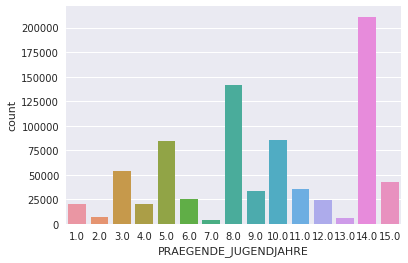

In [72]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
sns.countplot(df_until_threshold['PRAEGENDE_JUGENDJAHRE'])

In [73]:
def decade_feature(data):
    if data in [-1, 0]:
        return np.nan
    elif data in [1, 2]:
        return 40
    elif data in [3, 4]:
        return 50
    elif data in [5, 6, 7]:
        return 60
    elif data in [8, 9]:
        return 70
    elif data in [10, 11, 12, 13]:
        return 80
    else: # [14, 15]
        return 90

In [74]:
def movement_feature(data):
    if data in [-1, 0]:
        return np.nan
    
    elif data in [1, 3, 5, 8, 10, 12, 14]:
        # 0 for Mainstream
        return 0 
    else:
        # 1 for Avantgarde
        return 1

In [75]:
df_until_threshold['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_until_threshold.PRAEGENDE_JUGENDJAHRE.apply(decade_feature)

df_until_threshold['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df_until_threshold.PRAEGENDE_JUGENDJAHRE.apply(movement_feature)

In [76]:
df_until_threshold[['PRAEGENDE_JUGENDJAHRE','PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT' ]].head()

,PRAEGENDE_JUGENDJAHRE,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT
1,14.0,90,0
2,15.0,90,1
3,8.0,70,0
4,8.0,70,0
5,3.0,50,0


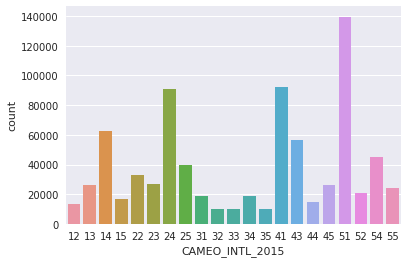

In [77]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
sns.countplot(df_until_threshold['CAMEO_INTL_2015'])

In [78]:
df_until_threshold['CAMEO_INTL_2015'] = df_until_threshold['CAMEO_INTL_2015'].astype('int')
df_until_threshold['CAMEO_INTL_2015_ONES'] = df_until_threshold['CAMEO_INTL_2015'].apply(lambda x: x%10)
df_until_threshold['CAMEO_INTL_2015_TENS'] = df_until_threshold['CAMEO_INTL_2015'] - df_until_threshold['CAMEO_INTL_2015_ONES']


In [79]:
df_until_threshold[['CAMEO_INTL_2015', 'CAMEO_INTL_2015_ONES', 'CAMEO_INTL_2015_TENS']].head()

,CAMEO_INTL_2015,CAMEO_INTL_2015_ONES,CAMEO_INTL_2015_TENS
1,51,1,50
2,24,4,20
3,12,2,10
4,43,3,40
5,54,4,50


#### Discussion 1.2.2: Engineer Mixed-Type Features

 > **Engineering steps to handle Mixed-Type features ?**

        PRAEGENDE_JUGENDJAHRE : Created two new features to capture the an interval-type variable for decade, and a binary variable for movement. 
        Written two different function decade_feature() and movement_feature() to achieve this. 

        CAMEO_INTL_2015 : Created two new features by break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables.
        * First convert CAMEO_INTL_2015 from object to integer. 
        * Module by 10 to find the last digit ( Ones )
        * Substract the original CAMEO_INTL_2015 with Ones to get the tens 
        
 > **Which ones to keep or drop ?**
 
     In the current implementation, we are keeping all of the mixed-types features. Did not drop anyone except the PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015, because we have created new features from these.
     


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [80]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [81]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

df_until_threshold.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], 
                          axis=1,
                          inplace=True)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [82]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    #Get missing_value_codes from feat_info dataframe
    missing_value_codes = feat_info.apply(get_missing_value_codes, axis=1)
    
    #convert missing_codes to NaN
    df,_,_ = transform_missing_codes_to_nan(df, missing_value_codes)
    
    # remove selected columns and rows, ...
    df = drop_outlier_features(df)
    #print("Drop Outlier features: ",df.shape)
    df_until_threshold, _ = divide_data_by_missing_threshold(df, 19)
    #print("df_no_missing_values",df_no_missing_values.shape)
    
    missing_columns = df_until_threshold.columns[ df_until_threshold.isnull().sum() > 0]
    print(len(missing_columns))

    for col in missing_columns:
        most_freq = df_until_threshold[col].mode()[0]
        df_until_threshold[col] = df_until_threshold[col].fillna(most_freq)
    
    # select, re-encode, and engineer column values.
    _, binary_categorical_required_encoding, multi_level_required_encoding = assess_categorical_features(df_until_threshold)
    df_until_threshold = pd.get_dummies(data=df_until_threshold, columns=binary_categorical_required_encoding + multi_level_required_encoding)
    
    
    # Engineer columns
    df_until_threshold['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_until_threshold.PRAEGENDE_JUGENDJAHRE.apply(decade_feature)
    df_until_threshold['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df_until_threshold.PRAEGENDE_JUGENDJAHRE.apply(movement_feature)
    
    
    df_until_threshold['CAMEO_INTL_2015'] = df_until_threshold['CAMEO_INTL_2015'].astype('int')
    df_until_threshold['CAMEO_INTL_2015_ONES'] = df_until_threshold['CAMEO_INTL_2015'].apply(lambda x: x%10)
    df_until_threshold['CAMEO_INTL_2015_TENS'] = df_until_threshold['CAMEO_INTL_2015'] - df_until_threshold['CAMEO_INTL_2015_ONES']

    df_until_threshold.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], 
                          axis=1,
                          inplace=True)
    
    # Return the cleaned dataframe.
    return df_until_threshold
    

In [83]:
df_transformed = clean_data(azdias)

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')
46


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [84]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

df_transformed.isnull().sum()

ALTERSKATEGORIE_GROB              0
ANREDE_KZ                         0
FINANZ_MINIMALIST                 0
FINANZ_SPARER                     0
FINANZ_VORSORGER                  0
FINANZ_ANLEGER                    0
FINANZ_UNAUFFAELLIGER             0
FINANZ_HAUSBAUER                  0
GREEN_AVANTGARDE                  0
HEALTH_TYP                        0
LP_LEBENSPHASE_FEIN               0
LP_LEBENSPHASE_GROB               0
RETOURTYP_BK_S                    0
SEMIO_SOZ                         0
SEMIO_FAM                         0
SEMIO_REL                         0
SEMIO_MAT                         0
SEMIO_VERT                        0
SEMIO_LUST                        0
SEMIO_ERL                         0
SEMIO_KULT                        0
SEMIO_RAT                         0
SEMIO_KRIT                        0
SEMIO_DOM                         0
SEMIO_KAEM                        0
SEMIO_PFLICHT                     0
SEMIO_TRADV                       0
SOHO_KZ                     

In [85]:
# Apply feature scaling to the general population demographics data.

st = StandardScaler()
df_scaled = st.fit_transform(df_transformed)

In [86]:
df_scaled

array([[-1.76617279,  0.95812115, -1.49446342, ..., -0.53065411,
        -1.24936851,  1.17585671],
       [ 0.20073336,  0.95812115, -1.49446342, ...,  1.88446671,
         0.76669146, -0.86959024],
       [ 1.18418644,  0.95812115,  0.68328531, ..., -0.53065411,
        -0.57734852, -1.55140589],
       ..., 
       [-0.78271971,  0.95812115, -0.76854718, ..., -0.53065411,
         0.76669146, -0.86959024],
       [-1.76617279, -1.04370935, -1.49446342, ..., -0.53065411,
        -1.24936851,  1.17585671],
       [ 1.18418644, -1.04370935,  0.68328531, ..., -0.53065411,
         0.09467147,  0.49404106]])

In [90]:
print("Mean after standard scaling : ", np.mean(df_scaled[:,1]).round(3))
print("Standard Deviation after standard scaling: ",np.std(df_scaled[:,1]))

Mean after standard scaling :  0.0
Standard Deviation after standard scaling:  1.0


### Discussion 2.1: Apply Feature Scaling

### StandardScaler:
        Standardize the features by removing the mean and scaling to unit variance.
        
        Steps:
            * Get the clean dataset
            * instantiate StandardScaler
            * Fit and Transform the data
        

        As we can see from the df_scaled output above, StandardScaler changed the scale of the original dataframe.
        The converted feature has 0 mean and 1 std as expected.
        


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [91]:
# Apply PCA to the data.
pca = PCA()
pca.fit(df_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [92]:
print(df_scaled.shape)
print(pca.components_.shape)


(797077, 197)
(197, 197)


In [93]:
pca_index = np.arange(0,len(pca.components_),1)

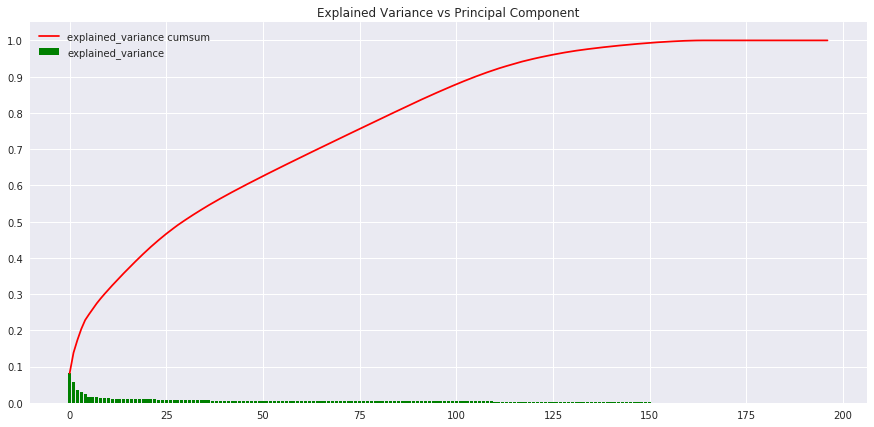

In [94]:
# Investigate the variance accounted for by each principal component.
plt.figure(figsize=(15,7))
plt.yticks(np.arange(0, 2, 0.1))
plt.title("Explained Variance vs Principal Component")
plt.plot(pca.explained_variance_ratio_.cumsum(), label = 'explained_variance cumsum', color='red')
plt.bar(pca_index, pca.explained_variance_ratio_, color = 'green', label='explained_variance')
plt.legend(loc='upper left')

In [95]:
df_scaled.shape

(797077, 197)

In [96]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=25)
X_pca = pca.fit_transform(df_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

 > **PCA Findings ?**
 
         Above plot shows two differnet plots. Red one is the cumulative sum of explained variance ratio and green one is the explained variance ratio by each principal component.
         
         From the above plot it is very clear that highest variance explaine by the First PC is approx 0.09.Then it started reducing.
         Almost 50% variance has explained by first 25 Principal Components. Other Prinicipal Components are doing minor contribution that makes the Cumulative sum close to 1.
         
         In the current implementation, going with first 25 Principal Components, this also covers the good 50% variance of the data for the next step of analysis.
         

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [97]:
df_scaled.shape

(797077, 197)

In [98]:
print(pca.components_.shape)
print(X_pca.shape)

(25, 197)
(797077, 25)


In [99]:
df_transformed.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A', 'CAMEO_DEU_2015_9B',
       'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D', 'CAMEO_DEU_2015_9E',
       'PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT',
       'CAMEO_INTL_2015_ONES', 'CAMEO_INTL_2015_TENS'],
      dtype='object', length=197)

In [100]:
#cols = [ 'f_'+str(i) for i in range(1,df_scaled.shape[1]+1)]
cols = list(df_transformed.columns)

In [101]:
pca.components_[0].shape

(197,)

In [102]:
def pos_foo(data):
    #print("foo",data.values[0])
    if data.values[0] < 0:
        #print("if")
        return 0
    else:
        #print("else")
        return data.values[0]
    
def neg_foo(data):
    #print("foo",data.values[0])
    if data.values[0] > 0:
        #print("if")
        return 0
    else:
        #print("else")
        return data.values[0]


In [103]:
def pca_results(pca, features, selected_components, top_features = 20):
    '''
        Visualizes the PCA results
        Includes dimension feature weights and explained variance
        Input:
            pca
            features
            selected_components : Principal Component which we want to visualize
            top_features : selecting top positive and negative weights features to visualize
    '''
    
    #selected_components = 2
    #top_features = 20
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_[selected_components-1].reshape(1,-1), 4), columns = features)
    #components.index = dimensions

    print(components.shape)

    positive_components = components.apply(pos_foo, axis=0)
    neg_components = components.apply(neg_foo, axis=0)

    pos_labels = positive_components[positive_components.apply(lambda x: x > 0)]
    neg_labels = neg_components[neg_components.apply(lambda x: x > 0)]
    
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (20,8))

    # Plot the feature weights as a function of the components
    tmp_pos = pd.DataFrame(positive_components.values.reshape(1,-1), columns=positive_components.index)
    tmp_pos.sort_values(by=0, axis=1, inplace=True, ascending=False)

    tmp_neg = pd.DataFrame(neg_components.values.reshape(1,-1), columns=neg_components.index)
    tmp_neg.sort_values(by=0, axis=1, inplace=True, ascending=True)
    
    top_pos_features = tmp_pos.columns[:top_features]
    top_neg_features = tmp_neg.columns[:top_features]
    
    
    
    tmp_pos[top_pos_features].plot(ax = ax, kind = 'bar', color = 'green');
    tmp_neg[top_neg_features].plot(ax = ax, kind = 'bar', color='red');
    
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(["Principal Component : "+str(selected_components)], rotation=0)

    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_[selected_components-1].reshape(1,-1)):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))


In [104]:
def analyse_principal_component(pca, component, features):
    '''
        analyse_principal_component function maps the weight for the principal component to corresponding feature names.
        Input: pca object, component , features 
        Output: list of feature names and weights 
    '''
    weights = pca.components_[component]
    return [ (features[i], weights[i] ) for i in np.argsort(weights)[::-1] ]


In [105]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

component_1_mapping = analyse_principal_component(pca,0, cols)
component_1_mapping

[('LP_STATUS_GROB_1.0', 0.18887109934454302),
 ('HH_EINKOMMEN_SCORE', 0.17999197862095631),
 ('CAMEO_INTL_2015_TENS', 0.17856713358937495),
 ('PLZ8_ANTG3', 0.17815411438969919),
 ('PLZ8_ANTG4', 0.17282696020612018),
 ('PLZ8_BAUMAX', 0.16985164155556629),
 ('ORTSGR_KLS9', 0.15246012146806046),
 ('EWDICHTE', 0.15033885784835405),
 ('FINANZ_HAUSBAUER', 0.14722107574157633),
 ('KBA05_ANTG4', 0.12651061477660852),
 ('LP_STATUS_FEIN_1.0', 0.1252129963032651),
 ('PLZ8_ANTG2', 0.12182642552933941),
 ('KBA05_ANTG3', 0.11369699288839806),
 ('ANZ_HAUSHALTE_AKTIV', 0.11352041834655033),
 ('ARBEIT', 0.11196691901686956),
 ('CAMEO_DEUG_2015_9', 0.11020006480747746),
 ('LP_STATUS_FEIN_2.0', 0.10808119949919558),
 ('RELAT_AB', 0.10476520434975052),
 ('LP_FAMILIE_GROB_1.0', 0.10389133930576935),
 ('LP_FAMILIE_FEIN_1.0', 0.10389133930576935),
 ('FINANZTYP_1', 0.10332618429932473),
 ('FINANZ_SPARER', 0.10182919624343453),
 ('CAMEO_DEUG_2015_8', 0.087841121845965028),
 ('SEMIO_PFLICHT', 0.0721373609498922

(1, 197)


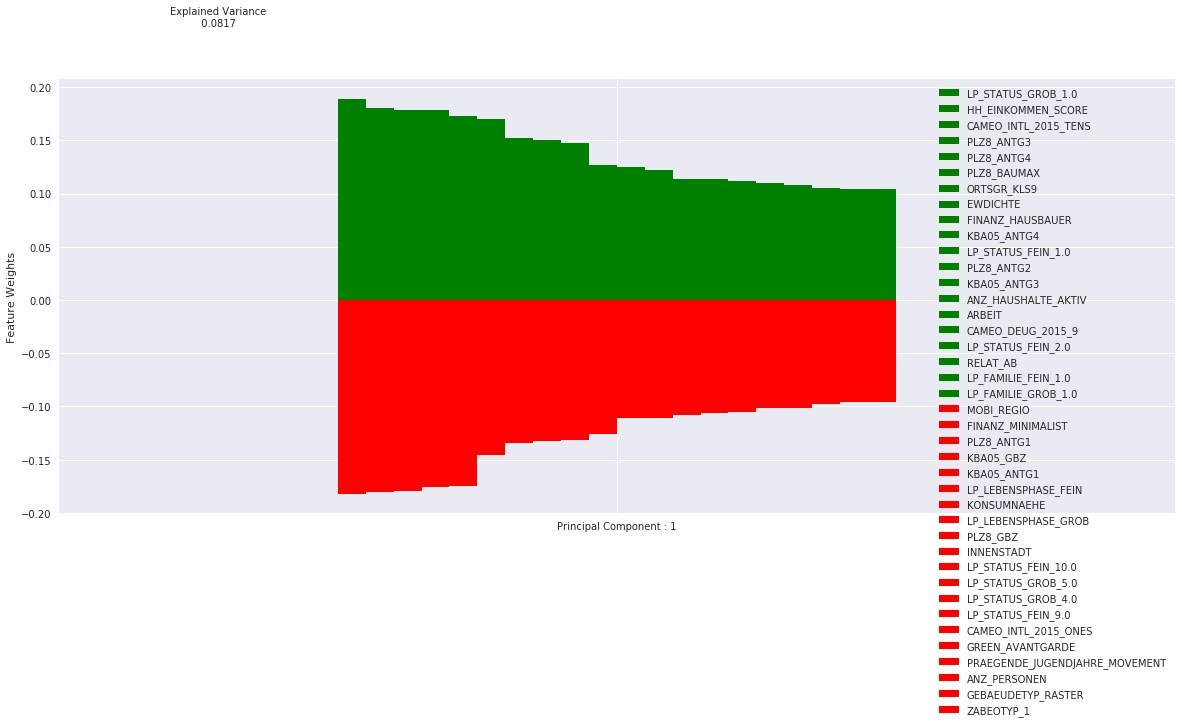

In [106]:
pca_results(pca, cols, 1)

In [107]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

component_2_mapping = analyse_principal_component(pca,1, cols)
component_2_mapping

[('ALTERSKATEGORIE_GROB', 0.23694180926440844),
 ('FINANZ_VORSORGER', 0.22227848118938615),
 ('ZABEOTYP_3', 0.19953703139205581),
 ('SEMIO_ERL', 0.18139803314017497),
 ('SEMIO_LUST', 0.16578955671859252),
 ('RETOURTYP_BK_S', 0.15485702233087068),
 ('W_KEIT_KIND_HH', 0.12424276401741471),
 ('CJT_GESAMTTYP_2.0', 0.11122756120810998),
 ('FINANZ_MINIMALIST', 0.10035505158317749),
 ('FINANZTYP_5', 0.097330807979239917),
 ('FINANZTYP_2', 0.096360639619233968),
 ('LP_STATUS_FEIN_1.0', 0.086597696577858208),
 ('FINANZ_HAUSBAUER', 0.076147938527876102),
 ('SHOPPER_TYP_3.0', 0.075868319964062722),
 ('CJT_GESAMTTYP_1.0', 0.07168434247110235),
 ('SEMIO_KRIT', 0.071480844028298407),
 ('NATIONALITAET_KZ_1.0', 0.070847942709928752),
 ('FINANZTYP_6', 0.069182890761660176),
 ('LP_FAMILIE_FEIN_1.0', 0.068443205909797439),
 ('LP_FAMILIE_GROB_1.0', 0.068443205909797439),
 ('GFK_URLAUBERTYP_4.0', 0.057792793470304714),
 ('WOHNDAUER_2008', 0.05579771368702257),
 ('SEMIO_KAEM', 0.053657801116464045),
 ('EWDI

(1, 197)


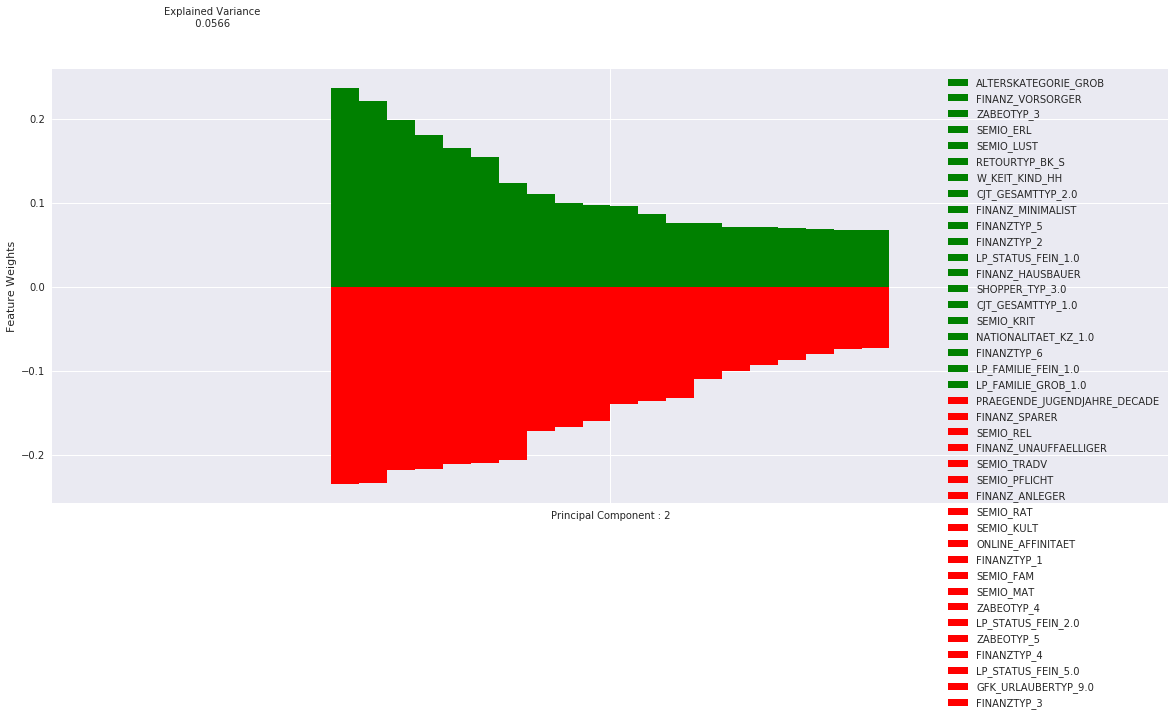

In [108]:
pca_results(pca, cols, 2)

In [109]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

component_3_mapping = analyse_principal_component(pca,2, cols)
component_3_mapping

[('SEMIO_VERT', 0.31270876012383869),
 ('SEMIO_FAM', 0.25356221235501741),
 ('SEMIO_SOZ', 0.25301038668806414),
 ('SEMIO_KULT', 0.24502161091511629),
 ('FINANZTYP_5', 0.13899361968376503),
 ('FINANZ_MINIMALIST', 0.1305777700751628),
 ('ZABEOTYP_1', 0.12176898318486276),
 ('SHOPPER_TYP_0.0', 0.12054574485288758),
 ('SEMIO_REL', 0.10995721803436947),
 ('PRAEGENDE_JUGENDJAHRE_MOVEMENT', 0.094537903722125324),
 ('GREEN_AVANTGARDE', 0.094537903722125324),
 ('SEMIO_MAT', 0.086076672355303571),
 ('ORTSGR_KLS9', 0.079096425416227384),
 ('EWDICHTE', 0.078337429622656871),
 ('RETOURTYP_BK_S', 0.073615371837940716),
 ('LP_STATUS_GROB_5.0', 0.069535463216326421),
 ('LP_STATUS_FEIN_10.0', 0.069535463216326421),
 ('PLZ8_BAUMAX', 0.058989471312637334),
 ('PLZ8_ANTG4', 0.057273952451700583),
 ('PLZ8_ANTG3', 0.056827961878569692),
 ('LP_STATUS_FEIN_3.0', 0.047690028418898509),
 ('FINANZ_VORSORGER', 0.046712939385014536),
 ('ZABEOTYP_6', 0.045384959502157797),
 ('W_KEIT_KIND_HH', 0.044898725786104002),


(1, 197)


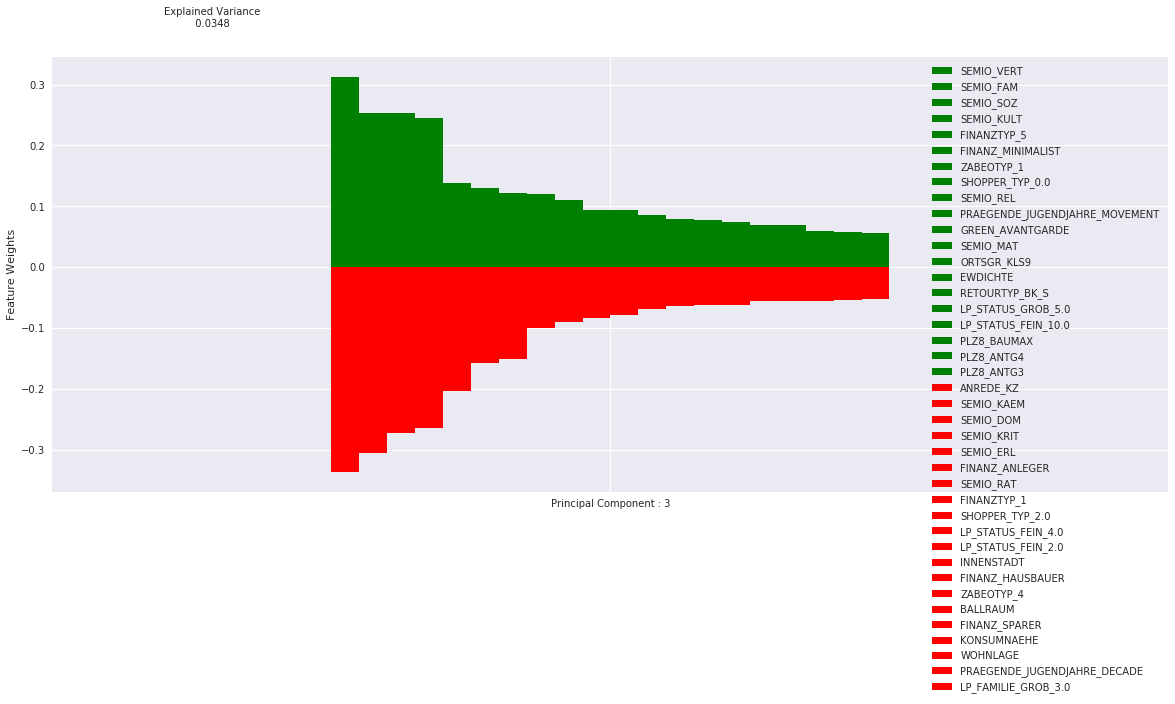

In [110]:
pca_results(pca, cols, 3)

### Discussion 2.3: Interpret Principal Components

 > Can we interpret positive and negative values from them in a meaningful way ?
 
### Principal Component : 1

   * PC_1 explained **8.62%** (0.0862) variance of the data
   * PC_1 explains LP_STATUS_GROB_1.0 , HH_EINKOMMEN_SCORE , CAMEO_INTL_2015_TENS, PLZ8_ANTG3, PLZ8_ANTG4 etc are strongly connected.
   * PC_1 correlates most strongly with **LP_STATUS_GROB_1.0**
   * Strongly connected features denotes that if one increases, remaining will also increase.
   
   * -ve weight of MOBIE_REGIO, KBA05_ANTG1, FINANZ_MINIMALIST, PLZ8_ANTG1, KBA05_GBZ etc explains there is a inverse relation. 


### Principal Component : 2

   * PC_2 explained **5.9%** (0.0590) variance of the data
   * PC_2 explains ALTERSKATEGORIE_GROB, FINANZ_VORSORGER, ZABEOTYP_3, SEMIO_ERL, SEMIO_LUST etc are strongly connected.
   * PC_2 correlates most strongly with **ALTERSKATEGORIE_GROB**
   * Strongly connected features denotes that if one increases, remaining will also increase.
   
   * -ve weight of PRAEGENDE_JUGENDJAHRE_DECADE, FINANZ_SPARER, SEMIO_REL, SEMIO_PFLICHT, FINANZ_UNAUFFAELLIGER etc explains there is a inverse relation. 



### Principal Component : 3

   * PC_3 explained **3.63%** (0.0363) variance of the data
   * PC_3 explains SEMIO_VERT, SEMIO_FAM, SEMIO_SOZ, FINANZTYP_5, FINANZ_MINIMALIST etc are strongly connected.
   * PC_3 correlates most strongly with **SEMIO_VERT**
   * Strongly connected features denotes that if one increases, remaining will also increase.
   
   * -ve weight of ANREDE_KZ, SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT, SEMIO_ERL etc explains there is a inverse relation. 


 
 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [155]:
scores = []

In [156]:
centers = list(range(1,11))

In [157]:
# Over a number of different cluster counts...
for center in centers:

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(X_pca)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(X_pca))

    scores.append(score)
    print(center, score)
    

1 71491963.7667
2 61728950.1305
3 57338788.3435
4 54394139.286
5 52043559.7765
6 50594865.6593
7 49355812.3705
8 48167207.8903
9 47288446.503
10 46135366.9012


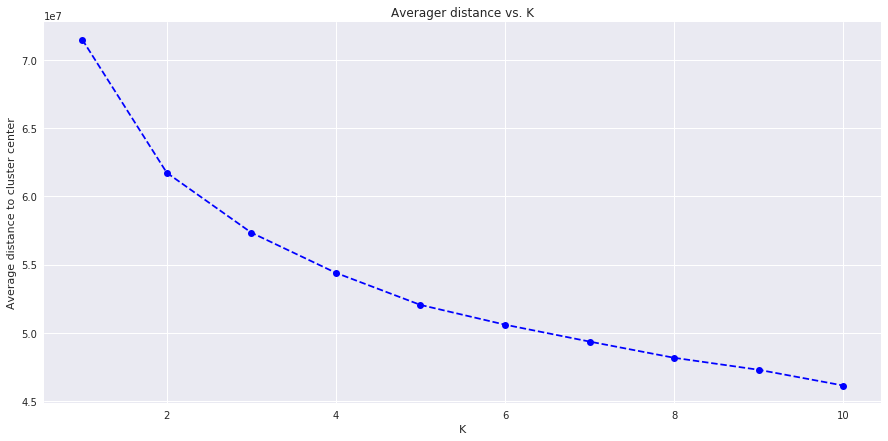

In [158]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(15,7))
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Average distance to cluster center');
plt.title('Averager distance vs. K');

In [115]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=4)
model = kmeans.fit(X_pca)
y_clusters = model.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

 > ### How many cluster segments ?
 
        After analysing the above sceer plot, choosing 4 cluster for further analysis and segmenting population data. 
  
        Eventhough we can not see a clear visible elbo point but we can see after K=4 that there is a slow decrease. 
  
        It's a kind of debatable to choose 4 or 3 cluster for segmenting the data.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [116]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=';')

In [117]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

print(customers.shape)
customers_clean_data = clean_data(customers)
print(customers_clean_data.shape)


(191652, 85)
Index(['TITEL_KZ'], dtype='object')
50


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(141176, 208)


In [118]:
extra_features_of_customers_data = set(customers_clean_data.columns) - set(df_transformed.columns)

print(extra_features_of_customers_data)

{'AGER_TYP_2.0', 'KBA05_BAUMAX', 'KK_KUNDENTYP_5.0', 'KK_KUNDENTYP_4.0', 'AGER_TYP_1.0', 'ALTER_HH', 'KK_KUNDENTYP_6.0', 'KK_KUNDENTYP_1.0', 'GEBURTSJAHR', 'AGER_TYP_3.0', 'KK_KUNDENTYP_3.0', 'KK_KUNDENTYP_2.0'}


In [119]:
features_of_population_not_in_customers = set(df_transformed.columns) - set(customers_clean_data.columns)
print(features_of_population_not_in_customers)

{'GEBAEUDETYP_5.0'}


In [120]:
customers_clean_data.drop(extra_features_of_customers_data, axis=1, inplace=True)

In [121]:
for feature in features_of_population_not_in_customers:
    customers_clean_data[feature] = 0

In [122]:
print(df_transformed.shape)
print(customers_clean_data.shape)

(797077, 197)
(141176, 197)


In [123]:
df_transformed.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A', 'CAMEO_DEU_2015_9B',
       'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D', 'CAMEO_DEU_2015_9E',
       'PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT',
       'CAMEO_INTL_2015_ONES', 'CAMEO_INTL_2015_TENS'],
      dtype='object', length=197)

In [124]:
customers_clean_data = customers_clean_data[df_transformed.columns]

In [125]:
customer_scale = st.transform(customers_clean_data)

customer_pca = pca.transform(customer_scale)

y_customer_clusters = kmeans.predict(customer_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

# Also represnting -1 cluster for missing_data from the analysis

In [183]:
print(y_clusters.shape)
print(azdias.shape)


(797077,)
(891221, 85)


In [171]:
from numpy import array

In [180]:
missing_data = azdias.shape[0] - y_clusters.shape[0]
y_general_population_cluster = np.append(y_clusters , array([-1]*missing_data))

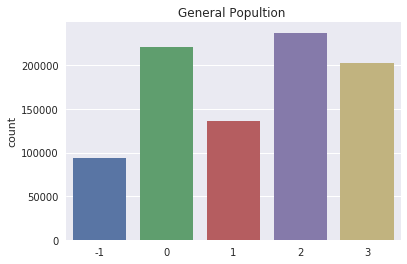

In [181]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

plt.title("General Popultion ")
sns.countplot(y_general_population_cluster)

In [182]:
print(y_customer_clusters.shape)
print(customers.shape)

(141176,)
(191652, 85)


In [184]:
missing_data = customers.shape[0] - y_customer_clusters.shape[0]

y_customer_clusters = np.append(y_customer_clusters , array([-1]*missing_data))

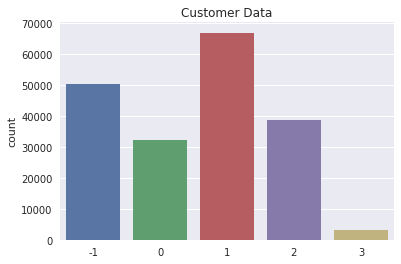

In [185]:
plt.title("Customer Data")
sns.countplot(y_customer_clusters)

### Cluster data distribution

In [131]:
def cluster_data_distribution(cluster_output):
    for i in range(4):
        print("Cluster: {0} has {1} % of data points ".
              format(i, round(sum(cluster_output == i)/len(cluster_output) , 2) * 100 ))

In [132]:
cluster_data_distribution(y_clusters)

Cluster: 0 has 28.000000000000004 % of data points 
Cluster: 1 has 17.0 % of data points 
Cluster: 2 has 30.0 % of data points 
Cluster: 3 has 25.0 % of data points 


In [133]:
cluster_data_distribution(y_customer_clusters)

Cluster: 0 has 23.0 % of data points 
Cluster: 1 has 47.0 % of data points 
Cluster: 2 has 27.0 % of data points 
Cluster: 3 has 2.0 % of data points 


In [152]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?


In [147]:
combine_df = pd.DataFrame(df_transformed[y_clusters==1].mode(axis=0).values.reshape(-1,1), 
                          columns=["general_population"],
                         index=df_transformed.columns)

combine_df['customer_data'] = customers_clean_data[y_customer_clusters==1].mode(axis=0).values.reshape(-1,1)

In [148]:
combine_df.head()

,general_population,customer_data
ALTERSKATEGORIE_GROB,3.0,4.0
ANREDE_KZ,1.0,1.0
FINANZ_MINIMALIST,5.0,5.0
FINANZ_SPARER,1.0,1.0
FINANZ_VORSORGER,5.0,5.0


In [151]:
combine_df[combine_df['general_population'] != combine_df['customer_data']]

,general_population,customer_data
ALTERSKATEGORIE_GROB,3.0,4.0
FINANZ_HAUSBAUER,1.0,2.0
HEALTH_TYP,2.0,1.0
LP_LEBENSPHASE_FEIN,13.0,40.0
SEMIO_FAM,3.0,4.0
SEMIO_MAT,1.0,6.0
SEMIO_ERL,4.0,3.0
SEMIO_KULT,3.0,4.0
SEMIO_RAT,4.0,3.0
SEMIO_DOM,5.0,3.0


 ### Overrepresented data ?
 As we can see from the above output difference between the customer and general population data, cluster 1 is overrepresented in customer data as compare to general population.
 
 * In General Population Estimated age based on given name analysis is 3: 46 - 60 years old but in Customer data is 4: > 60 years old
 
 * In General Population most frequent population are from 80s but in Customer data most frequent population are from 50s
 
 * In General Population most frequent life stage, final scale of population is 13: single top earners of higher age but in Customer data most frequent life state, final scale of population is - 40: top earners at retirement age from multiperson households


In [153]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

combine_df = pd.DataFrame(df_transformed[y_clusters==3].mode(axis=0).values.reshape(-1,1), 
                          columns=["general_population"],
                         index=df_transformed.columns)

combine_df['customer_data'] = customers_clean_data[y_customer_clusters==3].mode(axis=0).values.reshape(-1,1)

In [154]:
combine_df[combine_df['general_population'] != combine_df['customer_data']]

,general_population,customer_data
ALTERSKATEGORIE_GROB,1.0,2.0
FINANZ_SPARER,5.0,4.0
FINANZ_UNAUFFAELLIGER,4.0,5.0
FINANZ_HAUSBAUER,5.0,4.0
HEALTH_TYP,3.0,2.0
RETOURTYP_BK_S,1.0,4.0
SEMIO_KAEM,6.0,7.0
VERS_TYP,2.0,1.0
ANZ_HAUSHALTE_AKTIV,3.0,8.0
KBA05_GBZ,3.0,2.0


### Underepresented data ?
 As we can see from the above output difference between the customer and general population data, cluster 3 is underrepresented in customer data as compare to general population.
 
 * In General Population most frequent age group is 1: < 30 years old but in Customer data is 2: 30 - 45 years old
 
 * In General Population most frequent population belogs to 50: Poorer Households but in Customer data is 40: Less Affluent Households
 
 * In General Population most frequent health type of population is 3: jaunty hedonists but in Customer data is 2: sanitary affine

### Discussion 3.3: Compare Customer Data to Demographics Data

> ### Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?

    From the above countplots of general population and customer data and the figures of data distribution of cluster is very clear that Segment 1 is very popular with mail-order comanpy and Segment 3 is unpopular.
    
    Segment 1 , there is a higher proportion of persons in a cluster for the customer data compared to the general population, that is 47%.
    
    Segment 1, lower proportion of persons in a cluster for the customer data compared to the general population, that is 2%.
    
    

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.